In [1]:
import os
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import numpy as np

from REStats.utils import load_SCADA, filter_outliers

In [2]:
az.style.use("arviz-darkgrid")

In [3]:
wt = load_SCADA(2020)

AttributeError: PathCollection.set() got an unexpected keyword argument 'x_label'

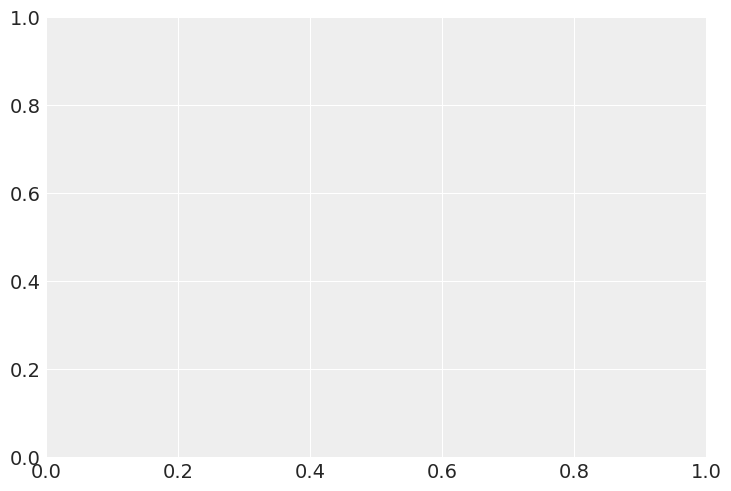

In [77]:
wt

plt.scatter(wt["Wind speed"], wt["Power"], s=1, alpha=0.2, xlabel="Wind speed (m/s)", ylabel="Power")

In [4]:
wt.head()

,Power,Wind direction,Wind speed
Date,,,
2020-01-01 00:00:00,150.984141,116.839462,3.887291
2020-01-01 00:10:00,130.414782,115.659361,3.848941
2020-01-01 00:20:00,146.401656,116.646515,4.043625
2020-01-01 00:30:00,84.296224,111.157642,3.330342
2020-01-01 00:40:00,94.994105,116.678227,3.388536


In [5]:
X = wt[(wt.index >= "2020-01-01") & (wt.index < "2020-03-01")]
X = X.fillna(0)
X.head()

,Power,Wind direction,Wind speed
Date,,,
2020-01-01 00:00:00,150.984141,116.839462,3.887291
2020-01-01 00:10:00,130.414782,115.659361,3.848941
2020-01-01 00:20:00,146.401656,116.646515,4.043625
2020-01-01 00:30:00,84.296224,111.157642,3.330342
2020-01-01 00:40:00,94.994105,116.678227,3.388536


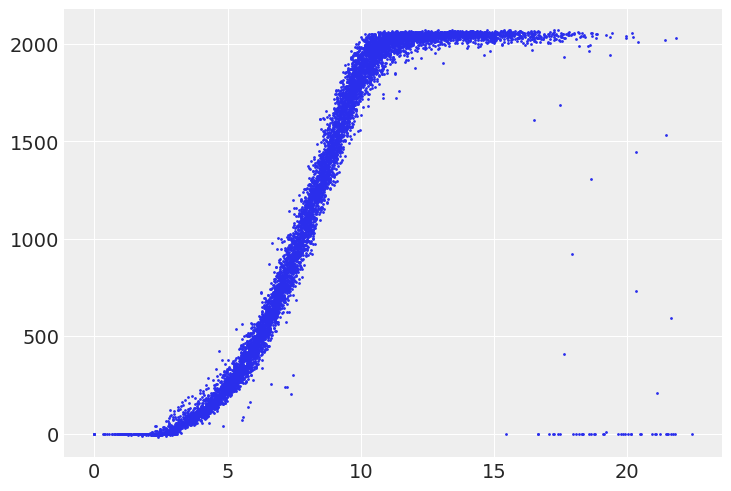

In [6]:
ax = plt.subplot()

ax.scatter(X["Wind speed"], X["Power"], s=1)

In [7]:
wt_filtered, wt_outliers = filter_outliers(X)

/home/cam/anaconda3/envs/REStats/lib/python3.11/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


/tmp/ipykernel_4100/2411028020.py:10: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


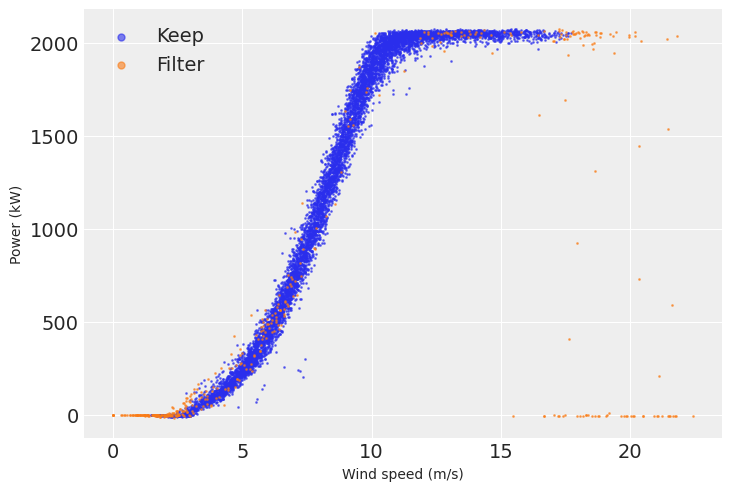

In [8]:
fig, ax = plt.subplots()

ax.scatter(wt_filtered["Wind speed"], wt_filtered["Power"], s=1, alpha=.6)
ax.scatter(wt_outliers["Wind speed"], wt_outliers["Power"], s=1, alpha=.6)
ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Power (kW)")

ax.legend(["Keep", "Filter"], markerscale=5)

fig.tight_layout()


In [72]:
wt_filtered.head()

,Power,Wind direction,Wind speed
Date,,,
2020-01-01 00:50:00,262.992229,127.755441,4.706282
2020-01-01 01:00:00,449.115810,131.613819,5.902455
2020-01-01 01:10:00,456.427864,134.693861,5.738715
2020-01-01 01:20:00,433.714243,130.266474,5.807972
2020-01-01 01:30:00,343.683160,137.579890,5.436982


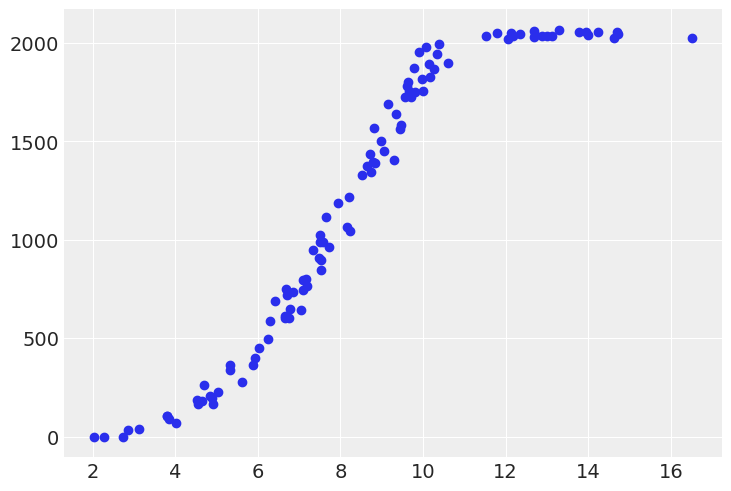

In [11]:
plt.scatter(wt_filtered["Wind speed"][::80], wt_filtered["Power"][::80])

In [26]:
N = 80
ws = wt_filtered["Wind speed"].values[::N, None]
X = ws
y = wt_filtered["Power"].values[::N]
y_mean = y.mean()

with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)
    cov_func = η**2 * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Marginal(cov_func=cov_func)
    sigma = pm.HalfCauchy("sigma", beta=5)
    
    y_ = gp.marginal_likelihood("y", X=X, y=y-y_mean, sigma=sigma)
    
    idata = pm.sample(chains=2, cores=1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ℓ, η, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 39 seconds.


In [27]:
Xnew = np.linspace(0, 20, 100)[:, None]

with model:
    fnew = gp.conditional("fnew", Xnew=Xnew)

In [28]:
with model:
    ppc = pm.sample_posterior_predictive(idata, var_names=["fnew"])

Sampling: [fnew]


array([[<Axes: title={'center': 'ℓ'}>, <Axes: title={'center': 'ℓ'}>],
       [<Axes: title={'center': 'η'}>, <Axes: title={'center': 'η'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

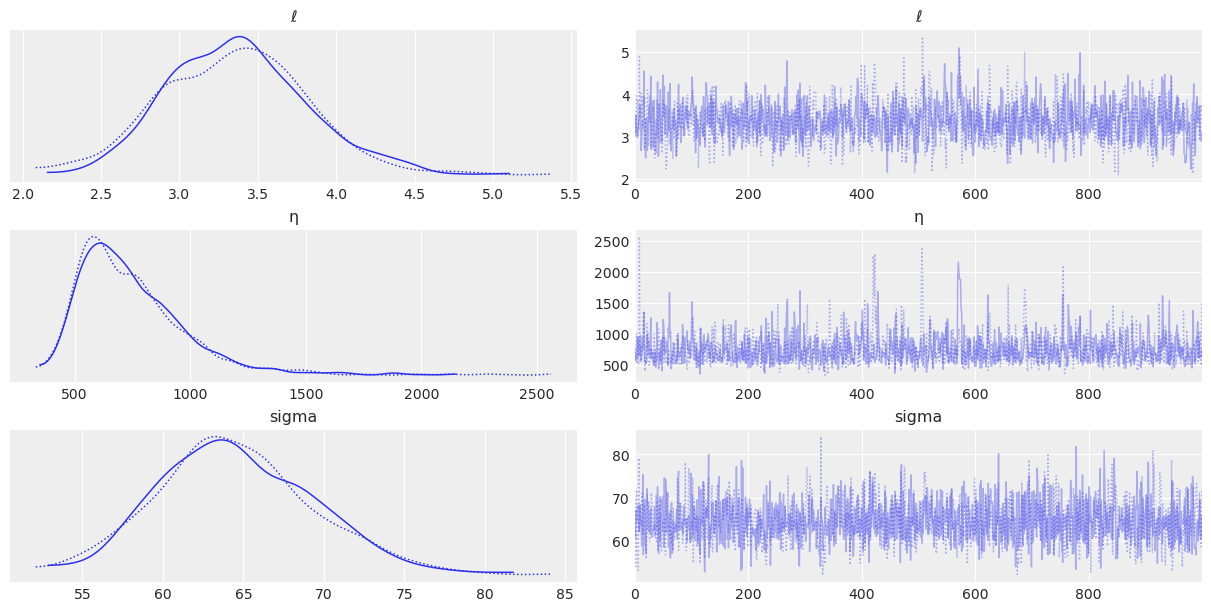

In [29]:
az.plot_trace(idata)

In [63]:
ppc.posterior_predictive.fnew[0]

<xarray.DataArray 'fnew' (draw: 1000, fnew_dim_2: 100)>
array([[ -804.19639555,  -859.2910094 ,  -912.36138195, ...,
          322.90234853,   314.15435053,   310.86248855],
       [ -630.31686851,  -706.77178357,  -780.85136605, ...,
          237.05298404,   221.32816244,   208.19392328],
       [ -942.77886978,  -988.96428029, -1031.40275408, ...,
          395.03796669,   377.38144989,   362.35466621],
       ...,
       [ -850.82263526,  -881.98789924,  -911.95323988, ...,
          460.33545424,   481.15768731,   508.72510629],
       [ -824.4885151 ,  -884.31030232,  -938.77837391, ...,
         1136.66440665,  1189.20480527,  1241.85677678],
       [ -846.59244641,  -893.98152593,  -941.75102129, ...,
         -223.21519896,  -282.12786133,  -337.08831455]])
Coordinates:
    chain       int64 0
  * draw        (draw) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
  * fnew_dim_2  (fnew_dim_2) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99

Text(0, 0.5, 'Power (kW)')

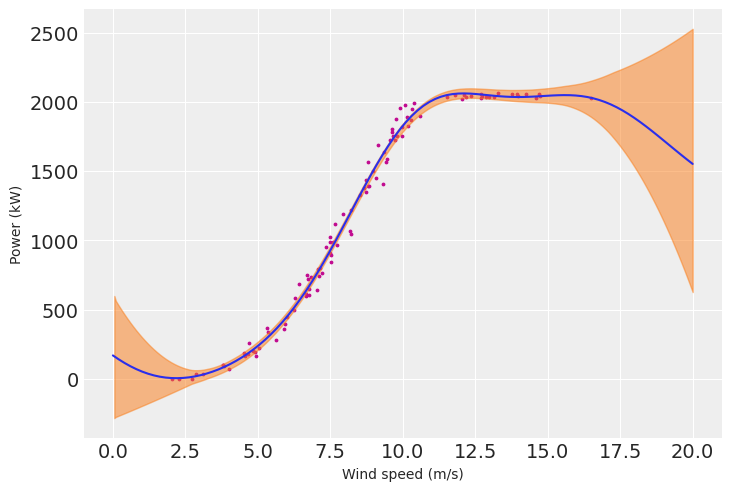

In [71]:
fig, ax = plt.subplots()

y_pred = ppc.posterior_predictive.fnew.mean(["chain", "draw"])

ax.plot(Xnew, y_pred + y_mean, color="C0")
ax.scatter(ws, y, s=3, color="C3")
az.plot_hdi(Xnew.flatten(), ppc.posterior_predictive.fnew + y_mean)

ax.set_xlabel("Wind speed (m/s)")
ax.set_ylabel("Power (kW)")